In [19]:
%matplotlib inline
import os.path
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.reflect import SLD, MaterialSLD, ReflectModel, Component
from refnx.analysis import Objective, CurveFitter, Transform, possibly_create_parameter
from refnx.analysis import Parameter, Parameters
from refnx.reflect import SLD, Slab, Structure, ReflectModel

from random import random
from scipy.ndimage import gaussian_filter1d

from tqdm import tqdm

In [20]:
#correct implementation
class PTCDI(Component):
    def __init__(
        self,
        nlayers,
        monolayer_thickness,
        rel_roughness,
        sld_box1,   # <----- this is closest to the phase layer
        sld_box2,
        thick_frac,
        sig1_rel_pos,  # <------ counting from backing to fronting direction
        sig1_width,
        sig2_rel_pos,  # <------ counting from backing to fronting direction
        sig2_width,
    ):
        super().__init__()
        self.nlayers = possibly_create_parameter(nlayers)
        self.monolayer_thickness = possibly_create_parameter(monolayer_thickness)
        self.rel_roughness = possibly_create_parameter(rel_roughness)
        self.sld_box1 = possibly_create_parameter(sld_box1)
        self.sld_box2 = possibly_create_parameter(sld_box2)
        self.thick_frac = possibly_create_parameter(thick_frac)
        self.sig1_rel_pos = possibly_create_parameter(sig1_rel_pos)
        self.sig1_width = possibly_create_parameter(sig1_width)
        self.sig2_rel_pos = possibly_create_parameter(sig2_rel_pos)
        self.sig2_width = possibly_create_parameter(sig2_width)

    @property
    def parameters(self):
        return Parameters([
            self.nlayers,
            self.monolayer_thickness,
            self.rel_roughness,
            self.sld_box1,
            self.sld_box2,
            self.thick_frac,
            self.sig1_rel_pos,
            self.sig1_width,
            self.sig2_rel_pos,
            self.sig2_width,
        ])
            
    def slabs(self, structure=None):
        nlayers = int(np.round(self.nlayers.value))
        monolayer_thickness = self.monolayer_thickness.value
        rel_roughness = self.rel_roughness.value        
        s_width1 = self.sig1_width.value
        s_width2 = self.sig2_width.value
        s_start1 = self.sig1_rel_pos.value
        s_start2 = self.sig2_rel_pos.value
        sld1 = self.sld_box1.value
        sld2 = self.sld_box2.value
        diff = sld2 - sld1
        mini, maxi = min(sld1, sld2), max(sld1, sld2)

        slabs = np.zeros((nlayers * 2, 5))
        t1 = monolayer_thickness * self.thick_frac.value
        t2 = monolayer_thickness * (1 - self.thick_frac.value)
        slabs[:, 0] = np.array([t1, t2] * nlayers)

        # why logistic, why not erf?
        def logistic(x, mini, maxi, k, x0):
            #return mini + (maxi - mini) / (1 + np.exp(-k * (x - x0)))
            return 0.5 * (erf(-k * (x - x0))) + 0.5

        idx = np.arange(nlayers * 2) / 2
        
        # note that the first monolayer has idx=0, and the last monolayer has idx=29.
        # if your indexing starts from 1, then sig1_rel_pos will be different by 1.
        sigmoid1 = logistic(idx, 1, 0, s_width1, s_start1)
        sigmoid2 = logistic(idx, 1, 0, s_width2, s_start2)
        #for i in range(45):
        #    if idx[i] > s_start2+2:
        #        sigmoid2[i] = 0      

        avg_sld = (sld1 + sld2) / 2
        diff = maxi - mini

        idx = np.arange(nlayers)

        if sld1 > sld2:
            slabs[2 * idx, 1] = sigmoid1 * ((maxi - avg_sld)*sigmoid2 + avg_sld)
            slabs[2*idx + 1, 1] = sigmoid1 * ((avg_sld - mini)*(1 - sigmoid2) + mini)
        else:
            slabs[2*idx + 1, 1] = sigmoid1[2*idx + 1] * ((maxi - avg_sld)*sigmoid2[2*idx + 1] + avg_sld)
            slabs[2 * idx, 1] = sigmoid1[2*idx] * ((avg_sld - mini)*(1 - sigmoid2[2*idx]) + mini)

        slabs[:, 3] = rel_roughness * monolayer_thickness
        # fronting medium comes first
        return slabs[::-1]

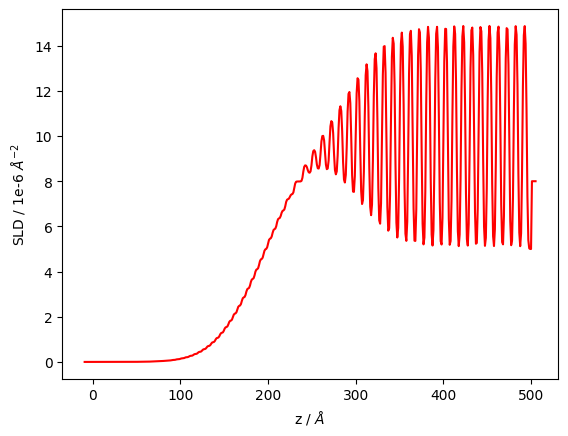

In [21]:
# a demonstration cell.
#         nlayers,
#         monolayer_thickness,
#         rel_roughness
#         sld_box1,
#         sld_diff,
#         thick_frac,
#         sig1_rel_pos,
#         sig1_width,
#         sig2_rel_pos,
#         sig2_width,
#         sig22_width,

c = PTCDI(50, 10, 0.1, 5, 15, 0.5, 30, 0.16, 20, 0.2)
s = SLD(0) | c | SLD(8)
# print(c.slabs())
s.plot();

In [22]:
air = SLD(0)

si = SLD(21.861 + 0.103j, "Si")
sio2 = SLD(21.2632+0.058j, "SiO2")

sio2_l = sio2(47, 1.2)

In [23]:
from multiprocessing import  Process, Queue, Lock

batch_size = 500

curves = []
q2 = np.linspace(0.015, 0.35, 256)
#Parameters

sld_box1 = np.random.uniform(low=4, high=8.5, size=batch_size)
sld_box2 = np.random.uniform(low=1, high=2, size=batch_size)


mono_thick = np.random.uniform(low=19.5, high=23.5, size=batch_size)

sig1_width = np.random.uniform(low=0.1, high=7, size=batch_size)
sig1_rel_pos = np.random.uniform(low=-0.2, high=30, size=batch_size)

sig2_width = np.random.uniform(low=0.5, high=3, size=batch_size)
sig2_rel_pos = np.random.uniform(low=1.5, high=29, size=batch_size)


for i in tqdm(range(batch_size)):
    
    sld_box2[i] = np.random.uniform(low=17-sld_box1[i]-3, high=17-sld_box1[i]+2, size=None)
    if sig1_rel_pos[i] <= 4:  
        sig2_rel_pos[i] = np.random.uniform(low=-0.15, high=sig1_rel_pos[i], size=None)
    if sig1_rel_pos[i] > 4 and sig1_rel_pos[i] <= 7:
        sig2_rel_pos[i] = np.random.uniform(3, sig1_rel_pos[i]+0.5, size=None)
    if sig1_rel_pos[i] > 7 and sig1_rel_pos[i] <= 12:
        sig2_rel_pos[i] = np.random.uniform(6, sig1_rel_pos[i]+0.5, size=None)
    if sig1_rel_pos[i] > 12 and sig1_rel_pos[i] <= 15:
        sig2_rel_pos[i] = np.random.uniform(7, sig1_rel_pos[i]+0.5, size=None)
    if sig1_rel_pos[i] > 15:
        sig2_rel_pos[i] = np.random.uniform(9, sig1_rel_pos[i]+2, size=None)
    
    if sig2_rel_pos[i] <= 0:
        sig2_width[i] = 1/5
    if sig2_rel_pos[i] > 0 and sig2_rel_pos[i] <= 4:
        sig2_width[i] = np.random.uniform(1/5, 1/0.5, size=None)
    if sig2_rel_pos[i] > 4 and sig2_rel_pos[i] <= 7:
        sig2_width[i] = np.random.uniform(1/4, 1/0.2, size=None)
    if sig2_rel_pos[i] > 7:
        sig2_width[i] = np.random.uniform(1/4, 1/0.1, size=None)
    
    # sig1 width
    if sig1_rel_pos[i] <= 0:
        sig1_width[i] = 1/5
    if sig1_rel_pos[i] > 0 and sig1_rel_pos[i] <= 3:
        sig1_width[i] = np.random.uniform(1/5, high=1/0.8, size=None)
    if sig1_rel_pos[i] > 3 and sig1_rel_pos[i] <= 6:
        sig1_width[i] = np.random.uniform(1/5, high=1/0.5, size=None)
    if sig1_rel_pos[i] > 6 and sig1_rel_pos[i] <= 14:
        sig1_width[i] = np.random.uniform(low=1/4, high=1/0.22, size=None)
    if sig1_rel_pos[i] > 14:
        sig1_width[i] = np.random.uniform(low=1/2.5, high=1/0.22, size=None)


    

    pol_slab = PTCDI(50, #nlayers,
                    mono_thick[i].round(4), #monolayer_thickness,
                    0.235, #rel_roughness
                    sld_box1[i].round(4), #sld_box1
                    sld_box1[i].round(4)+sld_box2[i].round(4), #sld_box2
                    0.5, #thick_frac,
                    sig1_rel_pos[i].round(4), #sig1_rel_pos,
                    1/sig1_width[i].round(4), #sig1_width,
                    sig2_rel_pos[i].round(4), #sig1_rel_pos,
                    1/sig2_width[i].round(4) #sig1_width,
                    )
    poly = SLD(17.0, "pol_inter")
    inter_l = poly(6.3, 5.59)
    s = air | pol_slab | inter_l | sio2_l | si(0, 1)
    model = ReflectModel(s, bkg=1e-9, dq=0.01, dq_type='pointwise')
    reflectivity = model(q2)
    curves.append(reflectivity)

labels = np.array([sld_box1.round(4),
                sld_box2.round(4),
                mono_thick.round(4),
                sig1_width.round(4),
                sig1_rel_pos.round(4),
                sig2_width.round(4),
                sig2_rel_pos.round(4)])

labels = labels.transpose()

labels_all = np.array(labels)
curves_all = np.array(curves)

print(labels_all[0,:])

print(labels_all.shape)
print(curves_all.shape)

100%|██████████| 500/500 [00:01<00:00, 335.53it/s]

[ 5.2765 13.5512 22.7838  3.7299 13.6411  3.1639  8.3575]
(500, 7)
(500, 256)


In [24]:
labels_all = np.reshape(labels_all, [500, 7])
curves_all = np.reshape(curves_all, [500, 256])
curves_all = np.array(curves_all, dtype='float32')

print(labels_all.shape)

print(curves_all.shape)


(500, 7)
(500, 256)


(500, 7)
(500, 256)


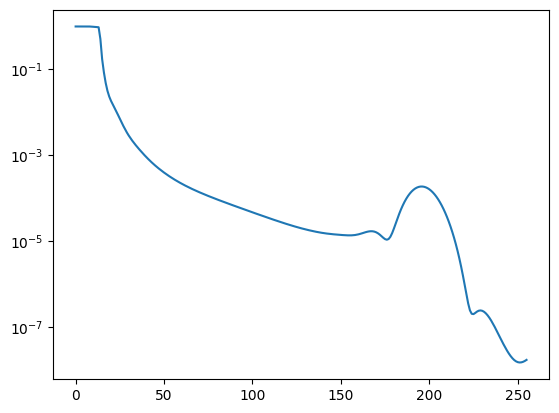

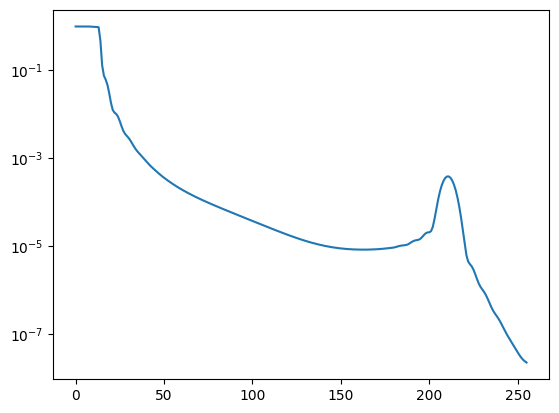

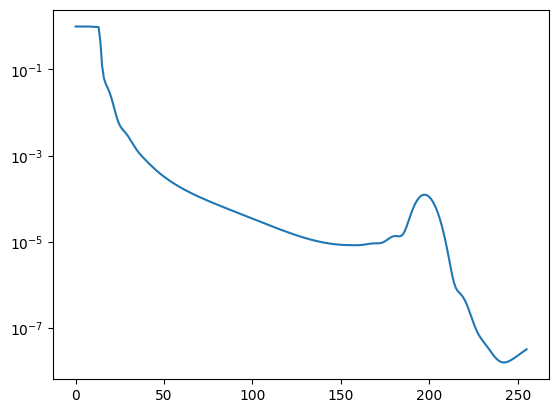

In [25]:
print(labels_all.shape)
print(curves_all.shape)

for i in range(3): 
    plt.plot(curves_all[i,:])
    plt.yscale('log')
    plt.show()

np.save('labels', labels_all)
np.save('curves', curves_all)
